## 绝对价差和相对价差的线性关系
研究绝对价差和相对价差的线性关系，从而研究规矩方法在两种标准下的表现差异

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import sys
sys.path.append('C:/Users/Administrator/Desktop/Repositories/Low-Frequency-Spread-Estimator')
sys.path.append('C:/Users/Handsome Bad Guy/Desktop/Repositories/Low-Frequency-Spread-Estimator')

from SpreadEstimator.SpreadEstimator import SpreadEstimator
from mytools.AutoTester import AutoTester

from time import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from tqdm import tqdm

plt.rcParams['font.sans-serif']=['KaiTi']
plt.rcParams['axes.unicode_minus'] = False

from sklearn.linear_model import LinearRegression

se = SpreadEstimator()

### 以HL为例研究为何表现在两种价差下相反
1. 首先研究价差和相对价差的关于平均价格的关系，可见相对加差随着价格增大减小，绝对价差则相反；
2. 如果用绝对价差版本的HL，反而相对价差的相关系数更加小；
3. 目前的情况来看，应该是极端值的影响，需要考虑如何解决；
4. 选取000505来看，它的收盘价上升的时候价差几乎不变，所以相对价差减小了，但是HL估计的相对价差和close正比
   
   思考原因，HL估计变大，就说明一日的最高最低价幅度的根号2倍要大于两日更多了，一种可能应该是，将更多的2日的负的拉成了正的
   
   观察走势，的确在大幅上涨的时候HL就是会高估

In [16]:
se.data.position_date_dic[50]

datetime.date(2020, 3, 20)

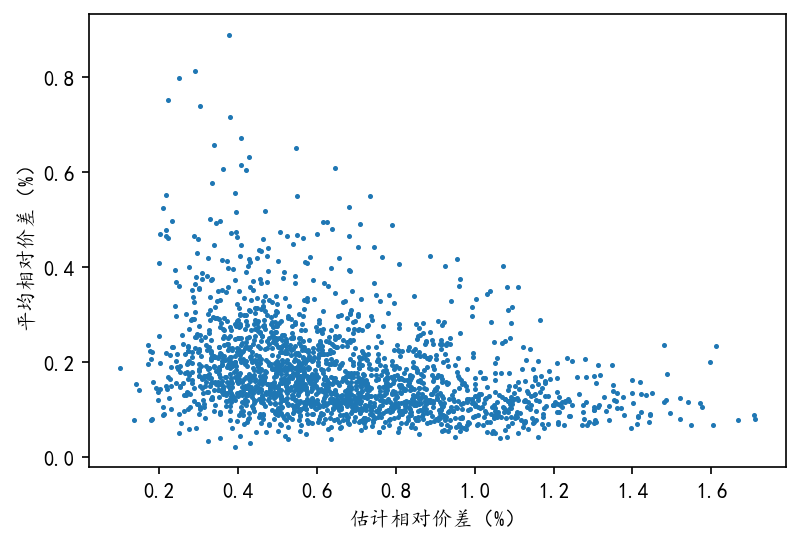

In [24]:
plt.figure(dpi=150)
sel = ~np.isnan(se.data.spread_dic['spread'])
close = se.data.data_dic['close']
spread = se.data.spread_dic['relative_spread']
plt.scatter(signal[50][sel[50]]*100, spread[50][sel[50]]*100, s=2)
plt.xlabel('估计相对价差（%）')
plt.ylabel('平均相对价差（%）')
plt.show()

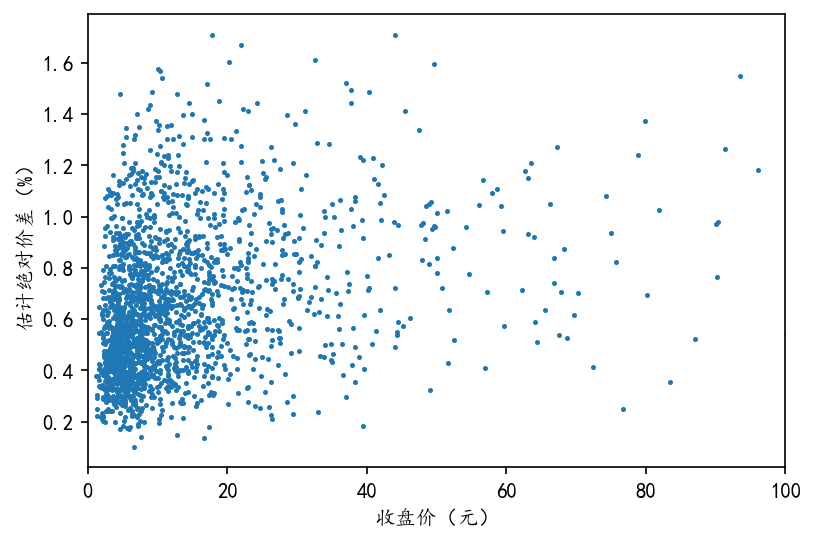

In [26]:
plt.figure(dpi=150)
sel = ~np.isnan(se.data.spread_dic['spread'])
close = se.data.data_dic['close']
spread = se.data.spread_dic['spread']
plt.scatter(close[50][sel[50]], signal[50][sel[50]]*100, s=2)
plt.xlabel('收盘价（元）')
plt.ylabel('估计绝对价差（%）')
plt.xlim([0, 100])
plt.show()

In [27]:
se.data.position_date_dic[50]

datetime.date(2020, 3, 20)

#### 然后我们研究价格和估计量的关系

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_35868/937919858.py:7: RuntimeWarning: Mean of empty slice
  spread[i] = np.nanmean(se.data.spread_dic['relative_spread'][i-20:i], axis=0)


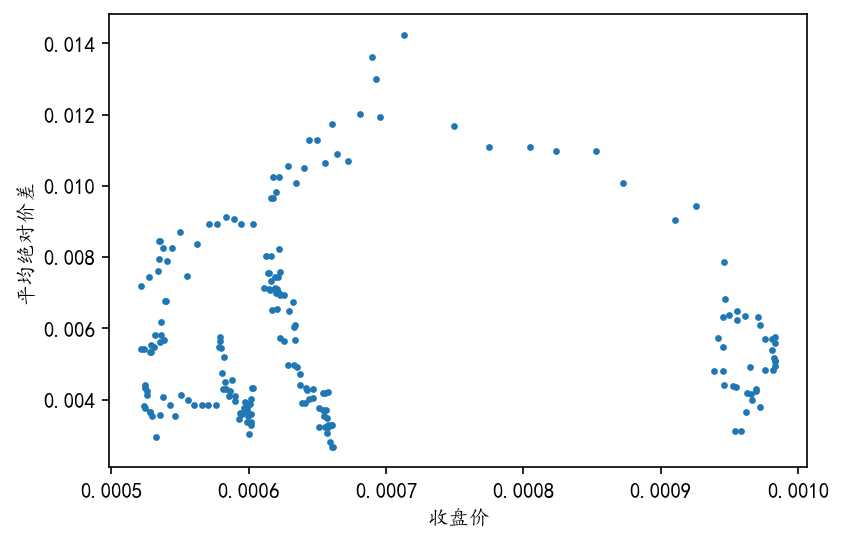

In [50]:

sel = (~np.isnan(se.data.spread_dic['relative_spread'])) & (~np.isnan(signal)) & (se.data.data_dic['close'] < 200)
close = se.data.data_dic['close'].copy()
for i in range(20,243):
    close[i] = np.nanmean(se.data.data_dic['close'][i-20:i], axis=0)
spread = se.data.spread_dic['relative_spread'].copy()
for i in range(20,243):
    spread[i] = np.nanmean(se.data.spread_dic['relative_spread'][i-20:i], axis=0)
plt.figure(dpi=150)
plt.scatter(spread[:,100][sel[:,100]], signal[:,100][sel[:,100]], s=5)
plt.xlabel('收盘价')
plt.ylabel('平均绝对价差')
plt.show()

# 为什么会有分团的情况呢

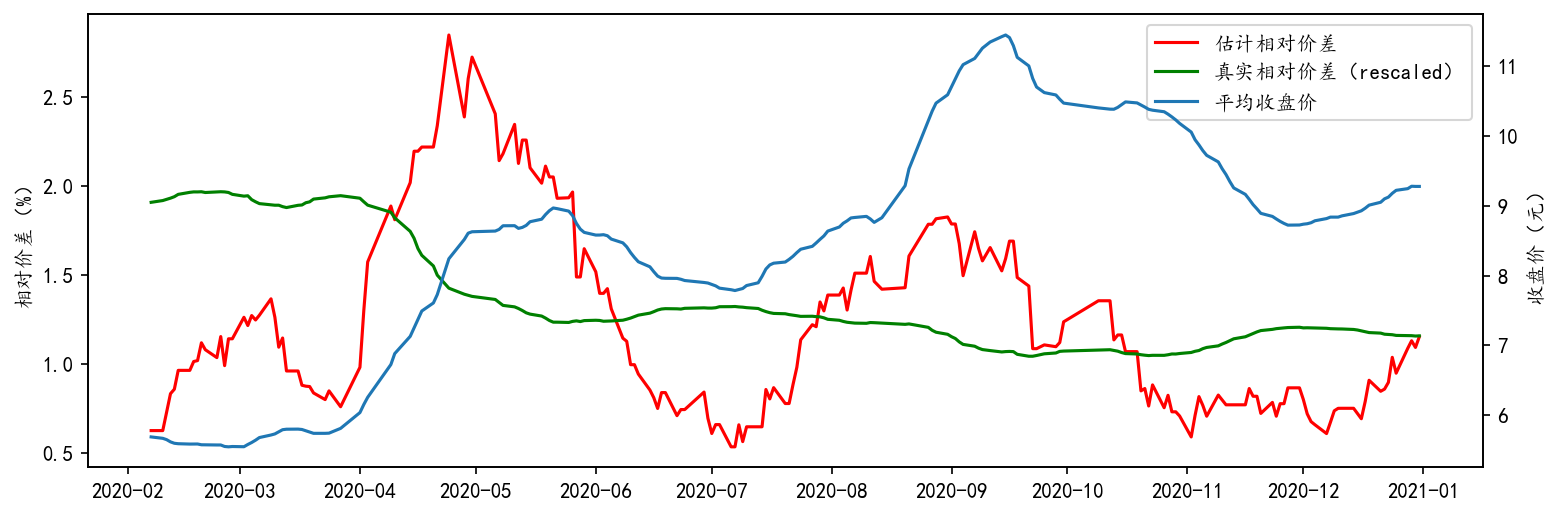

In [54]:
days = np.array([se.data.position_date_dic[i] for i in range(243)])[sel[:,100]]

fig = plt.figure(figsize=(12,4),dpi=150)
ax = fig.add_subplot(111)

lns1 = ax.plot(days, signal[:,100][sel[:,100]]*200, 'r', label='估计相对价差')
lns2 = ax.plot(days, spread[:,100][sel[:,100]]*2000, 'g', label='真实相对价差（rescaled）')
ax2 = ax.twinx()
lns3 = ax2.plot(days, close[:,100][sel[:,100]], label='平均收盘价')

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

ax.set_ylabel('相对价差（%）')
ax2.set_ylabel('收盘价（元）')
plt.xticks(rotation=45)
plt.show()


In [77]:
se.data.order_code_dic[100]

'000505'

In [76]:
np.corrcoef(close[:,100][sel[:,100]], signal[:,100][sel[:,100]])

array([[1.        , 0.22125827],
       [0.22125827, 1.        ]])

In [14]:
lr = LinearRegression()

beta = 'prod{tsmean{powv{minus{logv{high},logv{low}},2},2},2}'

high_1 = 'logv{tsdelay{high,1}}'
low_1 = 'logv{tsdelay{low,1}}'
con_1 = 'condition{gt{logv{low},logv{tsdelay{close,1}}},minus{logv{low},logv{tsdelay{close,1}}},minus{close,close}}'
con_2 = 'condition{lt{logv{high},logv{tsdelay{close,1}}},minus{logv{high},logv{tsdelay{close,1}}},minus{close,close}}'
con = 'add{' + con_1 + ',' + con_2 + '}'
high_2 = 'minus{logv{high},' + con + '}'
low_2 = 'minus{logv{low},' + con + '}'
high = 'condition{ge{' + high_1 + ',' + high_2 + '},' + high_1 + ',' + high_2 + '}'
low = 'condition{le{' + low_1 + ',' + low_2 + '},' + low_1 + ',' + low_2 + '}'

gamma = 'powv{minus{' + high + ',' + low + '},2}'
alpha = 'div{prod{' + 'powv{' + beta + ',0.5},0.4142},0.1716}'
fml = 'minus{' + alpha + ',' + 'powv{' + 'div{' + gamma + ',0.1716},0.5}}'

fml = 'div{' + 'minus{expv{' + fml + '},1},' + 'add{expv{' + fml + '},1}}'
fml = 'condition{' + 'ge{' + fml +',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'


print('cs_rel_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='cs', spread_type='relative_spread', back=20)

print('cs_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='cs', spread_type='spread', back=20)


cs_rel_sp
mean corr: -0.1741, positive_corr_ratio: 0.0000, corr_IR: -2.8080
cs_sp
mean corr: 0.1909, positive_corr_ratio: 1.0000, corr_IR: 3.0568


In [58]:
lr = LinearRegression()

beta = 'prod{tsmean{powv{minus{high,low},2},2},2}'

high_1 = 'tsdelay{high,1}'
low_1 = 'tsdelay{low,1}'
con_1 = 'condition{gt{low,tsdelay{close,1}},minus{low,tsdelay{close,1}},minus{close,close}}'
con_2 = 'condition{lt{high,tsdelay{close,1}},minus{high,tsdelay{close,1}},minus{close,close}}'
con = 'add{' + con_1 + ',' + con_2 + '}'
high_2 = 'minus{high,' + con + '}'
low_2 = 'minus{low,' + con + '}'
high = 'condition{ge{' + high_1 + ',' + high_2 + '},' + high_1 + ',' + high_2 + '}'
low = 'condition{le{' + low_1 + ',' + low_2 + '},' + low_1 + ',' + low_2 + '}'

gamma = 'powv{minus{' + high + ',' + low + '},2}'
alpha = 'div{prod{' + 'powv{' + beta + ',0.5},0.4142},0.1716}'
fml = 'minus{' + alpha + ',' + 'powv{' + 'div{' + gamma + ',0.1716},0.5}}'

fml = 'div{' + 'minus{expv{' + fml + '},1},' + 'add{expv{' + fml + '},1}}'
fml = 'condition{' + 'ge{' + fml +',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'


print('cs_rel_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='cs', spread_type='relative_spread', back=20)

print('cs_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='cs', spread_type='spread', back=20)

print('ts_rel_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='ts', spread_type='relative_spread', back=20)

print('ts_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='ts', spread_type='spread', back=20)


cs_rel_sp
mean corr: -0.4630, positive_corr_ratio: 0.0000, corr_IR: -16.7947
cs_sp
mean corr: 0.7400, positive_corr_ratio: 1.0000, corr_IR: 20.5674
ts_rel_sp
mean corr: -0.3346, positive_corr_ratio: 0.2020, corr_IR: -0.8321
ts_sp
mean corr: 0.4855, positive_corr_ratio: 0.8990, corr_IR: 1.4419


In [34]:
lr = LinearRegression()

fml = 'close'

print('cs_rel_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='cs', spread_type='relative_spread', back=20)

print('cs_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='cs', spread_type='spread', back=20)

print('ts_rel_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='ts', spread_type='relative_spread', back=20)

print('ts_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='ts', spread_type='spread', back=20)

cs_rel_sp
mean corr: -0.3880, positive_corr_ratio: 0.0000, corr_IR: -9.2479
cs_sp
mean corr: 0.8474, positive_corr_ratio: 1.0000, corr_IR: 31.1736
ts_rel_sp
mean corr: -0.6282, positive_corr_ratio: 0.0879, corr_IR: -1.7128
ts_sp
mean corr: 0.3480, positive_corr_ratio: 0.8087, corr_IR: 0.9155


### 挑选一只相对价差大的股票

In [12]:
rs = se.data.spread_dic['relative_spread'][50].copy()
rs[np.isnan(rs)] = -10
se.data.order_code_dic[np.argsort(rs)[-2]]

'000816'

In [8]:
se.data.spread_dic['spread'][50][658]

0.0099999999999998